# Identificación de huellas de calzado a partir de imágenes con redes neuronales convolucionales 

## Diferentes medidas de las imágenes

El objetivo de este apartado es entrenar la red neuronal utilizando diferentes medidas de imágenes para comprobar si el tamaño de estas afecta al resultado.





In [2]:
#librerias necesarias:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
import skimage
import cv2 
from datetime import datetime


## Lectura

In [3]:
def unzipImages(folder='images'):
    with ZipFile('data/2dFootwear/Part1.zip', 'r') as zipObj:
      zipObj.extractall(folder)

    with ZipFile('data/2dFootwear/Part2.zip', 'r') as zipObj:
      zipObj.extractall(folder)
    with ZipFile('data/2dFootwear/Part3.zip', 'r') as zipObj:
      zipObj.extractall(folder)

    with ZipFile('data/2dFootwear/Part4.zip', 'r') as zipObj:
      zipObj.extractall(folder)

    with ZipFile('data/2dFootwear/Part5.zip', 'r') as zipObj:
      zipObj.extractall(folder)

In [4]:
if not os.path.isdir("images_full"):
    unzipImages("images_full")

In [5]:
df = pd.read_csv('data/2dFootwear/Data-information.csv', delimiter=';')
df['Brand'] = df['Brand'].str.strip() #eliminar espacios en blanco

X_files = df['ID'].values.tolist()
brands = df['Brand'].values.tolist()
values_brand, counts_brand = np.unique(brands, return_counts=True)
num_classes = len(values_brand) #se guarda porque será necesario para crear el modelo



In [6]:

def filterMinSamples(data, minSamples, deleteNone=True):
    if deleteNone == True:
        data=data[data['x']!="None"] #eliminar marca = "None"
    dataone=data[data['y']<minSamples] #marcas con pocas muestras
    data=data[data['y']>=minSamples] #marcas con minimo "minSamples" muestras
    num_classes=len(data)
    print('Brands with at least '+str(minSamples)+' samples: %d' %num_classes) 
    print('Brands with only 1 register: %d' %len(dataone)) 
    return data, dataone

dfbrandall = pd.DataFrame({'x':values_brand, 'y':counts_brand}) 

dfbrand, dfbrandone = filterMinSamples(dfbrandall, 5)

num_classes=len(dfbrand)
dfbrand = dfbrand.sort_values('y', ascending = False) #ordenar descendientemente




Brands with at least 5 samples: 7
Brands with only 1 register: 52


In [7]:
def crop_jpeg(crop_size, imgPath):
    dir_list = os.listdir("./"+imgPath)
    for f in dir_list:
        im = Image.open("./"+imgPath+"/"+f)
        h,w,c = im.shape
        im3 = im2.crop((crop_size,crop_size,h-(crop_size*2),w-(crop_size*2))) #Quitar marco medidor

def new_size_jpeg(new_w, new_h, imgPath):
    dir_list = os.listdir("./"+imgPath)
    for f in dir_list:
        im = Image.open("./"+imgPath+"/"+f)
        im2=im.resize((new_w, new_h))
        im2.save("./"+imgPath+"/"+f[0:-4]+'jpeg')

def get_images_full_to_jpeg(imgPath):
  dir_list = os.listdir("./"+imgPath)
  result = []

  for f in dir_list:

    im = Image.open("./"+imgPath+"/"+f)
    im2=im.resize((1965, 4563))
    im3 = im2.crop((160,160,1645, 4212)) #Quitar marco medidor
    im3.save("./"+imgPath+"/"+f[0:-4]+'jpeg')
    
    result.append(f[0:-4]+'jpeg')
    os.remove("./"+imgPath+"/"+f)

  print('Nº files:',len(result))
  return result


def get_images_to_jpeg(imgPath):
  dir_list = os.listdir("./"+imgPath)
  result = []

  for f in dir_list:

    im = Image.open("./"+imgPath+"/"+f)
    im2=im.resize((400,912))
    im3 = im2.crop((40,40,320,872)) #Quitar marco medidor
    im3.save("./"+imgPath+"/"+f[0:-4]+'jpeg')
    
    result.append(f[0:-4]+'jpeg')
    os.remove("./"+imgPath+"/"+f)

  print('Nº files:',len(result))
  return result

def get_images(imgPath):
  dir_list = os.listdir("./"+imgPath)
  result = []
  for f in dir_list:  
    if "jpeg" in f:
        result.append(f)


  print('Nº files:',len(result))
  return result

In [8]:
#shoeFilesFull = get_images_full_to_jpeg("images_full") #execute first time only
shoeFilesFull = get_images("images_full")

Nº files: 1500


### Visualización de imágenes

Se ha creado la función *plot_image* que permite la visualización de las imágenes de cualquiera de las dos bases de datos.

Parámetros:\
*imgPath*: carpeta donde estan las imágenes \
*fileNames*: array con los nombres de los ficheros a mostrar

In [9]:

import skimage
def plot_image(imgPath, fileNames):
  for i in range(len(fileNames)):
    filename = fileNames[i]
    img = skimage.io.imread(imgPath+filename)
   
    plt.figure()
    plt.title(str(img.shape)+" , "+str(img.dtype))
    plt.imshow(img)
  print(fileNames)
  plt.show()

def plot_image2(img):

    plt.figure()
    plt.title(str(img.shape)+" , "+str(img.dtype))
    plt.imshow(img)

    plt.show()
def plot_image_grey(img):

    plt.figure()
    plt.title(str(img.shape)+" , "+str(img.dtype))
    plt.imshow(img, cmap='gray')

    plt.show()

In [10]:
def filesWithBrand(shoeFiles):
  files = []
  brands = []
  for image in shoeFiles:
    files.append(image) #filename
    person = df[df['ID'].str[:6]==image[:6]]  #persona+contador de calzado
    brands.append(person['Brand'].iloc[0])

  return pd.DataFrame({'X':files, 'y':brands}) 

def filterBrands(data, one, deleteNone=True):
    #dfbrandone creado antes con las marcas que no cumplen.
    df_shoe_brand=data[~data['y'].isin(one['x'].to_numpy())]
    if deleteNone == True:
        df_shoe_brand=df_shoe_brand[df_shoe_brand['y']!="None"]
    df_shoe_brand['factor_brand'] = pd.Categorical(pd.factorize(df_shoe_brand['y'])[0].astype(np.float32))
    
    return df_shoe_brand

df_shoe_brand_all = filesWithBrand(shoeFilesFull) #contiene todas las muestras

#eliminar aquellas marcas que no aparecen mínimo en "minSample" muestras 
df_shoe_brand = filterBrands(df_shoe_brand_all,dfbrandone)
#número de marcas con 5 o más muestras:
print('Nº of brands: %d' %num_classes)
show_brands = df_shoe_brand.drop_duplicates(subset = "y")
show_brands = show_brands[['y','factor_brand']]
show_brands

Nº of brands: 7


,y,factor_brand
3,Asics,0.0
8,Skechers,1.0
15,Sperry,2.0
17,Adidas,3.0
18,Nike,4.0
31,Converse,5.0
57,Saucony,6.0


In [11]:
def checkBalancedSample(train, test, val):
    checkTest = False
    checkVal = False
    
    #Comprobar si existen en train
    test_in = test.y.isin(train.y).astype(int)
    val_in=val.y.isin(train.y).astype(int)

    #Comprobar que existen todos (todo 1)  
    if all(x==1 for x in test_in):
        checkTest = True
    if all(x==1 for x in val_in):
        checkVal = True
    #Devuelve True si en test y val aparecen marcas que existen en train:
    if checkTest and checkVal:
        return True
    return False

In [12]:
from sklearn.model_selection import train_test_split
def  split_datafiles(df):
  X_train, X_test = train_test_split(df, test_size=0.2 , random_state=random.randint(0,32),shuffle=True)

  X_train, X_val = train_test_split(X_train, test_size=0.14, random_state=random.randint(0,32),shuffle=True) # 0.14 x 0.7 = 0.1
  return X_train,  X_test ,X_val

#Dividir conjunto de datos:
shoes_train, shoes_test, shoes_val = split_datafiles(df_shoe_brand)

while checkBalancedSample(shoes_train, shoes_test, shoes_val) == False:
    shoes_train, shoes_test, shoes_val = split_datafiles(df_shoe_brand)

In [13]:
from skimage import io
img = io.imread("images_full/"+shoeFilesFull[0])

full_w, full_h, full_c = img.shape #se guarda el tamaño de las imágenes.

In [14]:
!pip install opencv-contrib-python==4.4.0.44 


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


## Entrenar el modelo según tamaño de imagen


In [15]:
#Se ha creado un generador para añadir la aumentación de las imágenes
import torchvision.io
import torch
from tensorflow.keras.utils import Sequence
import torchvision.transforms as T
from torchvision.transforms import Resize
from skimage.io import imread
from skimage.util import img_as_float,random_noise
from skimage.transform import rotate
from skimage.color import rgb2gray
import numpy as np
import random
import os

from skimage import transform, util
import cv2  as cv



#función que elimina las filas y columnas en blanco:
def crop_image(gray, pixel_value=220):
    #gray = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    
    crop_rows = gray[~np.all(gray > pixel_value, axis=1), :]
    cropped_image = crop_rows[:, ~np.all(crop_rows > pixel_value, axis=0)]
    return cropped_image

def create_variation(theImage,doFlip,doNoise,doRotate):
  image = img_as_float(theImage)
  if doFlip==True:
    image = np.fliplr(image)
  if doNoise==True:
    image = util.random_noise(image)
  if doRotate==True:
    image = transform.rotate(image, random.randint(-45, 45),mode='symmetric')
  return image

class DataGenerator2dFootwear(Sequence):
    # Constructor. Input parameters are:
    # * fileNames   : List of sample file names
    # * doRandomize : If True, the provided file names are shuffled after each training epoch
    #                 and each image can be left unchanged, flipped, corrupted with
    #                 noise or rotated. 8 possible combinations is chosen randomly with equal probability.
    #                 If False, file names are not shuffled and each image is provided unchanged.
    # * imgPath     : Path to the images 
    # * batchSize   : Number of sample images and ground truth items in each batch
    def __init__(self,data, df_shoe_brand,w,h,doRandomize=False,imgPath='images', doGray=True,doBin=True, doCrop = True,batchSize=10):
        # Store parameters
        self.imgPath=imgPath
        self.fileNames=data.copy()
        self.batchSize=batchSize
        self.doRandomize=doRandomize
        self.df_shoe_brand=df_shoe_brand
        self.doGray=doGray
        self.doBin=doBin
        self.doCrop=doCrop
        self.orig_w=w
        self.orig_h=h
        # Get number of files (to avoid computing them later)
        self.numImages=len(data)
        # Shuffle them if required
        self.on_epoch_end()

    # Shuffle data if required
    def on_epoch_end(self):
        if self.doRandomize:
            random.shuffle(self.fileNames)

    # Returns the number of total batches
    def __len__(self):
        return int(np.ceil(float(self.numImages)/float(self.batchSize)))

    
    # Input  : theIndex - Index of the image to load within self.fileNames.
    # Output : theImage - Loaded (and possibly transformed) image. Must be
    #                     of float type with values within [0,1]
    #          theClass - Shoe brand
    def _load_image_(self,theIndex):

   
        file = self.fileNames[theIndex]  
        

        img = io.imread(self.imgPath+file)
        
        img = cv2.resize(img, (self.orig_w,self.orig_h), interpolation = cv2.INTER_AREA)
    
        h,w,c = img.shape
        if self.doGray:#escala de grises
            img = rgb2gray(img)
            #plot_image_grey(img)
        if self.doBin: #blanco y negro
            test_binary_high,img = cv.threshold(img,0, 255, cv2.THRESH_BINARY)
        if self.doCrop: #quitar columnas/filas blancas
            img = crop_image(img)
            img = cv2.resize(img, (h,w), interpolation = cv2.INTER_AREA)
        
        theImage = img_as_float(img)
        
        theImage=theImage /255.0 #normalizar (quito rescaling del modelo)
        #print(theImage.shape)
        #añadir aumentación a las imágenes:
        if self.doRandomize:
          theImage=create_variation(img,random.choice([True, False]),random.choice([True, False]),random.choice([True, False])) 
        #else:
         # theImage=create_variation(img,False, False, False)

        #Buscar la imagen en el csv para extraer la Marca:
        person = self.df_shoe_brand[self.df_shoe_brand['X'].str[:6]==file[:6]]  #persona+contador de calzado
        theClass = person['factor_brand'].iloc[0]#self.classes[theIndex] #¿debe ser numérico o podría ser la etiqueta?
        return theImage,theClass

    # Provides the images,class batch
    # Batch format:
    # - X : The data. Numpy array of shape (bs,nr,nc,3)
    # - y : The ground truth. Numpy array of shape (bs,1)
    # Where nb=batch size, nr=num rows, nc=num cols
    def __getitem__(self,theIndex):
        X=[]
        y=[]
        bStart=max(theIndex*self.batchSize,0)
        bEnd=min((theIndex+1)*self.batchSize,self.numImages)
        for i in range(bStart,bEnd):
            [curImage,curGT]=self._load_image_(i)
            X.append(curImage)
            y.append(curGT)
        return np.array(X),np.array(y)
    
    


In [16]:

from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Softmax, Rescaling, Dropout
import tensorflow as tf
def createModelTest(color, w, h):
    if color == True:
        shape = (h,w,3)
    else:
        shape = (h,w,1)
    #print(shape)
    model_test = models.Sequential([
      #Rescaling(1./255, input_shape=(280,832,3)),
      Conv2D(16, 3, padding='same', activation='relu', input_shape=shape),
      MaxPooling2D(),
      Conv2D(32, 3, padding='same', activation='relu'),
      MaxPooling2D(),
      Conv2D(64, 3, padding='same', activation='relu'),
      MaxPooling2D(),
      Flatten(),
      Dense(128, activation='relu'),
      Dropout(0.5),
      Dense(num_classes, activation='softmax'),
      Flatten()
    ])
    return model_test

In [17]:

def plot_history(history):
# summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_history_2(history):
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [18]:
def showResult(predicted, test, array):
    filename = test['X']
    img = skimage.io.imread("images/"+filename)
   
    plt.figure()
    plt.title(test['y']+" "+str(test['factor_brand']))
    plt.imshow(img)
    if array == True:
        print(predicted)
        sort_index = np.argsort(-predicted)
        print(sort_index)
    else:
        print(predicted)

In [19]:
#Calular porcentaje que aparecen en las 3 primera posiciones 
def getXfirstOk(predicted, test, x):
    sort_index = np.argsort(-predicted)
    if test['factor_brand'] in sort_index[:x]:
        return True
    return False
  

In [20]:
def checkAccuracyFirstPositions(predicted_y, shoes_test, x):
    total = len(predicted_y)
    ok = 0
    for i in range(total):
        if getXfirstOk(predicted_y[i],shoes_test.iloc[i],x):
            ok = ok+1

    print(ok)
    print(ok/total)


In [21]:
#Devuelve el % de veces que la marca se predijo con un porcentage >= minPercent
#Porcentaje de aceptación.
def checkBrandPercent(predicted_y, shoes_test, minPercent):
    total = len(predicted_y)
    ok = 0
    for i in range(total):
        #print(shoes_test['factor_brand'].iloc[i])
        #print(predicted_y[int(shoes_test['factor_brand'].iloc[i])])
        if predicted_y[0][int(shoes_test['factor_brand'].iloc[i])] >= minPercent: 
            ok = ok+1

    print(ok/total)


In [22]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,ConfusionMatrixDisplay

def printConfMatrix(predicted, test, n ):
    sort_index = np.argsort(-predicted)
    cm = confusion_matrix(test['factor_brand'],[item[0] for item in sort_index])

    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = range(n))

    cm_display.plot()
    plt.show() 

In [23]:
def checkModel(modelTest, testGenerator, n, test):
    predicted_y = modelTest.predict(testGenerator)
    print("Test evaluation:")
    print(modelTest.evaluate(testGenerator)) #first position
    print("% of correct brand in the first 3 positions:")
    checkAccuracyFirstPositions(predicted_y, test,3)
    print("% of brand predicted with percentage >= 0.25") #independent from position
    checkBrandPercent(predicted_y, test,0.25)
    print("% of brand predicted with percentage >= 0.5") 
    checkBrandPercent(predicted_y, test,0.5)
    print("% of brand predicted with percentage >= 0.75") 
    checkBrandPercent(predicted_y, test,0.75)
    if n<=20:
        print("Matriz de confusión:") 
        printConfMatrix(predicted_y,test,n)


In [24]:
def fitModelSize(aumentation, gray, binary, crop, epoch, w, h):
   
    modelTest = createModelTest(not gray,w,h)
    modelTest.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
    
    #Configurar el preprocesado que se hará en las imágenes desntro del Generator.
    trainGenerator=DataGenerator2dFootwear(shoes_train['X'].tolist(),df_shoe_brand, w,h,aumentation, "images_full/", gray, binary, crop)
    testGenerator=DataGenerator2dFootwear(shoes_test['X'].tolist(),df_shoe_brand, w,h,False, "images_full/", gray, binary, crop)
    valGenerator=DataGenerator2dFootwear(shoes_val['X'].tolist(),df_shoe_brand, w,h,False, "images_full/", gray, binary, crop)
    print(" ")
   
    print('Training model with aumentation:'+str(aumentation)+', gray:'+str(gray)+', binary:'+str(binary)+', crop:'+str(crop)+' and epochs = '+str(epoch))
    trainHistory = modelTest.fit(trainGenerator,validation_data=valGenerator, epochs=epoch)
    
    plot_history(trainHistory)
    
    checkModel(modelTest,testGenerator, num_classes, shoes_test)
    
    return trainHistory, modelTest
    
    

In [ ]:
#Memory error:

start = datetime.now()
history, model_full_10_noaum = fitModelSize(False, True, True, True, 10, 1645, 4212)
end= datetime.now()

print("Time used: "+str(end-start))
model_full_10_noaum.save('models/full_10_noaum.h')


In [ ]:
#Memory error:
start = datetime.now()
history, model_full_10_aum = fitModelSize(True, True, True, True, 10, 1645, 4212)
end= datetime.now()

print("Time used: "+str(end-start))
model_full_10_aum.save('models/full_10_aum.h')

 
Training model with aumentation:False, gray:True, binary:True, crop:True and epochs = 10
Epoch 1/10
53/53 [==============================] - 241s 4s/step - loss: 5.1315 - accuracy: 0.3100 - val_loss: 1.5810 - val_accuracy: 0.3448
Epoch 2/10
53/53 [==============================] - 234s 4s/step - loss: 1.2679 - accuracy: 0.5406 - val_loss: 1.0183 - val_accuracy: 0.6667
Epoch 3/10
53/53 [==============================] - 202s 4s/step - loss: 0.6274 - accuracy: 0.8147 - val_loss: 0.7122 - val_accuracy: 0.7356
Epoch 4/10
53/53 [==============================] - 180s 3s/step - loss: 0.3028 - accuracy: 0.9055 - val_loss: 0.7219 - val_accuracy: 0.7816
Epoch 5/10
53/53 [==============================] - 184s 3s/step - loss: 0.1319 - accuracy: 0.9622 - val_loss: 0.4891 - val_accuracy: 0.7931
Epoch 6/10
53/53 [==============================] - 181s 3s/step - loss: 0.0870 - accuracy: 0.9754 - val_loss: 0.6234 - val_accuracy: 0.8161
Epoch 7/10
53/53 [==============================] - 179s 3s/ste

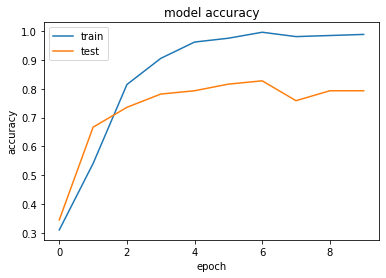

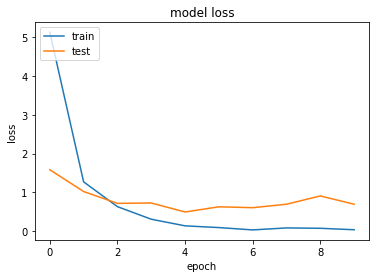

16/16 [==============================] - 25s 2s/step
Test evaluation:
16/16 [==============================] - 24s 1s/step - loss: 1.0315 - accuracy: 0.7922
[1.031463384628296, 0.7922077775001526]
% of correct brand in the first 3 positions:
149
0.9675324675324676
% of brand predicted with percentage >= 0.25
0.2662337662337662
% of brand predicted with percentage >= 0.5
0.2662337662337662
% of brand predicted with percentage >= 0.75
0.2662337662337662
Matriz de confusión:


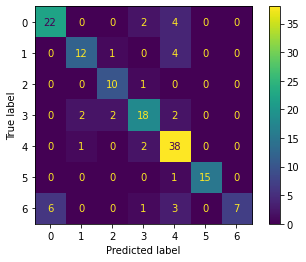

Time used: 0:33:54.487663


In [35]:
start = datetime.now()
history, model_10_noaum_411 = fitModelSize(False, True, True, True, 10, 411, 1053)
end= datetime.now()

print("Time used: "+str(end-start))


 
Training model with aumentation:True, gray:True, binary:True, crop:True and epochs = 10
Epoch 1/10
53/53 [==============================] - 133s 2s/step - loss: 8.2603 - accuracy: 0.2287 - val_loss: 1.8440 - val_accuracy: 0.3678
Epoch 2/10
53/53 [==============================] - 130s 2s/step - loss: 7.4866 - accuracy: 0.2495 - val_loss: 1.6755 - val_accuracy: 0.4138
Epoch 3/10
53/53 [==============================] - 130s 2s/step - loss: 7.6856 - accuracy: 0.2836 - val_loss: 1.5445 - val_accuracy: 0.3908
Epoch 4/10
53/53 [==============================] - 130s 2s/step - loss: 6.0975 - accuracy: 0.3346 - val_loss: 1.5162 - val_accuracy: 0.4368
Epoch 5/10
53/53 [==============================] - 131s 2s/step - loss: 6.8384 - accuracy: 0.3346 - val_loss: 1.3332 - val_accuracy: 0.5402
Epoch 6/10
53/53 [==============================] - 131s 2s/step - loss: 7.2106 - accuracy: 0.3611 - val_loss: 1.1362 - val_accuracy: 0.5862
Epoch 7/10
53/53 [==============================] - 131s 2s/step

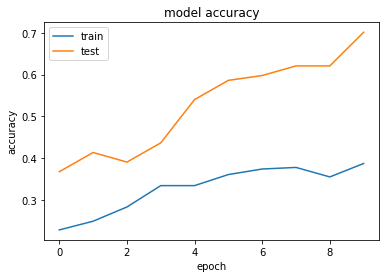

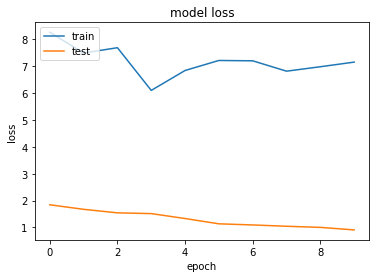

16/16 [==============================] - 20s 1s/step
Test evaluation:
16/16 [==============================] - 20s 1s/step - loss: 0.9971 - accuracy: 0.6429
[0.997138261795044, 0.6428571343421936]
% of correct brand in the first 3 positions:
143
0.9285714285714286
% of brand predicted with percentage >= 0.25
0.1038961038961039
% of brand predicted with percentage >= 0.5
0.1038961038961039
% of brand predicted with percentage >= 0.75
0.1038961038961039
Matriz de confusión:


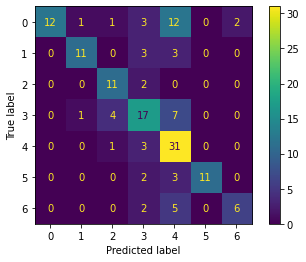

Time used: 0:22:33.542072


In [29]:
start = datetime.now()
history, model_10_aum_411 = fitModelSize(True, True, True, True, 10, 411, 1053)
end= datetime.now()

print("Time used: "+str(end-start))


 
Training model with aumentation:False, gray:True, binary:True, crop:True and epochs = 10
Epoch 1/10
53/53 [==============================] - 111s 2s/step - loss: 2.3427 - accuracy: 0.3025 - val_loss: 1.5303 - val_accuracy: 0.4138
Epoch 2/10
53/53 [==============================] - 108s 2s/step - loss: 1.3634 - accuracy: 0.5123 - val_loss: 1.2105 - val_accuracy: 0.5977
Epoch 3/10
53/53 [==============================] - 107s 2s/step - loss: 0.8146 - accuracy: 0.7221 - val_loss: 1.0097 - val_accuracy: 0.6897
Epoch 4/10
53/53 [==============================] - 108s 2s/step - loss: 0.5440 - accuracy: 0.8147 - val_loss: 0.8547 - val_accuracy: 0.7011
Epoch 5/10
53/53 [==============================] - 112s 2s/step - loss: 0.2482 - accuracy: 0.9149 - val_loss: 0.8833 - val_accuracy: 0.7011
Epoch 6/10
53/53 [==============================] - 103s 2s/step - loss: 0.2280 - accuracy: 0.9509 - val_loss: 0.9874 - val_accuracy: 0.7356
Epoch 7/10
53/53 [==============================] - 98s 2s/step

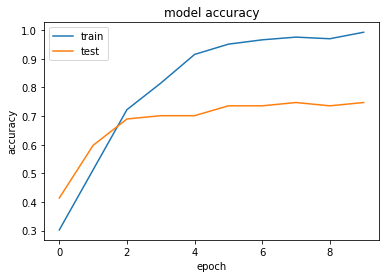

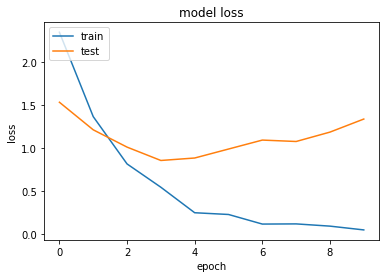

16/16 [==============================] - 20s 1s/step
Test evaluation:
16/16 [==============================] - 20s 1s/step - loss: 1.1437 - accuracy: 0.7792
[1.1437088251113892, 0.7792207598686218]
% of correct brand in the first 3 positions:
143
0.9285714285714286
% of brand predicted with percentage >= 0.25
0.2662337662337662
% of brand predicted with percentage >= 0.5
0.2662337662337662
% of brand predicted with percentage >= 0.75
0.2662337662337662
Matriz de confusión:


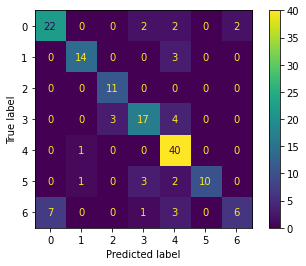

Time used: 0:18:18.532782


In [33]:
start = datetime.now()
history, model_10_noaum_205 = fitModelSize(False, True, True, True, 10, 205, 526)
end= datetime.now()

print("Time used: "+str(end-start))


 
Training model with aumentation:True, gray:True, binary:True, crop:True and epochs = 10
Epoch 1/10
53/53 [==============================] - 95s 2s/step - loss: 6.7183 - accuracy: 0.2892 - val_loss: 1.7032 - val_accuracy: 0.3678
Epoch 2/10
53/53 [==============================] - 94s 2s/step - loss: 6.5376 - accuracy: 0.3214 - val_loss: 1.7680 - val_accuracy: 0.3793
Epoch 3/10
53/53 [==============================] - 85s 2s/step - loss: 7.3357 - accuracy: 0.2609 - val_loss: 1.7636 - val_accuracy: 0.4023
Epoch 4/10
53/53 [==============================] - 83s 2s/step - loss: 6.8427 - accuracy: 0.2854 - val_loss: 1.4882 - val_accuracy: 0.4253
Epoch 5/10
53/53 [==============================] - 84s 2s/step - loss: 7.0881 - accuracy: 0.3100 - val_loss: 1.6697 - val_accuracy: 0.4368
Epoch 6/10
53/53 [==============================] - 84s 2s/step - loss: 6.7251 - accuracy: 0.3422 - val_loss: 1.3451 - val_accuracy: 0.4598
Epoch 7/10
53/53 [==============================] - 84s 2s/step - loss

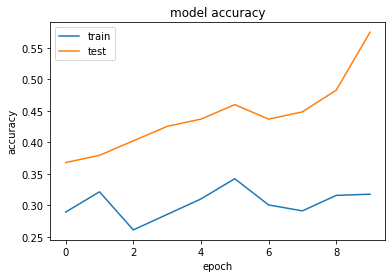

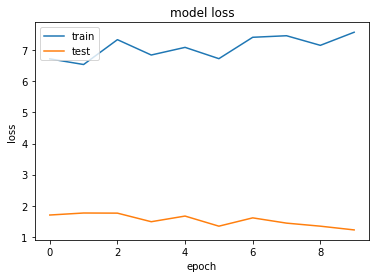

16/16 [==============================] - 17s 1s/step
Test evaluation:
16/16 [==============================] - 17s 1s/step - loss: 1.3121 - accuracy: 0.5260
[1.312137246131897, 0.5259740352630615]
% of correct brand in the first 3 positions:
135
0.8766233766233766
% of brand predicted with percentage >= 0.25
0.1038961038961039
% of brand predicted with percentage >= 0.5
0.1038961038961039
% of brand predicted with percentage >= 0.75
0.0
Matriz de confusión:


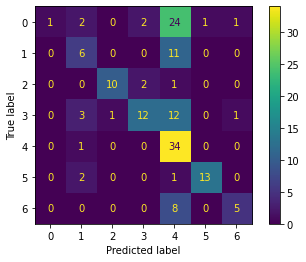

Time used: 0:14:57.575262


In [27]:
start = datetime.now()
history, model_10_aum_205 = fitModelSize(True, True, True, True, 10, 205, 526)
end= datetime.now()

print("Time used: "+str(end-start))


 
Training model with aumentation:False, gray:True, binary:True, crop:True and epochs = 10
Epoch 1/10
53/53 [==============================] - 350s 7s/step - loss: 2.7052 - accuracy: 0.3100 - val_loss: 1.4621 - val_accuracy: 0.4828
Epoch 2/10
53/53 [==============================] - 339s 6s/step - loss: 1.1632 - accuracy: 0.5784 - val_loss: 0.8954 - val_accuracy: 0.7241
Epoch 3/10
53/53 [==============================] - 143s 3s/step - loss: 0.6762 - accuracy: 0.7788 - val_loss: 0.6912 - val_accuracy: 0.8046
Epoch 4/10
53/53 [==============================] - 123s 2s/step - loss: 0.3141 - accuracy: 0.9112 - val_loss: 0.6437 - val_accuracy: 0.8276
Epoch 5/10
53/53 [==============================] - 122s 2s/step - loss: 0.1677 - accuracy: 0.9452 - val_loss: 0.6635 - val_accuracy: 0.8276
Epoch 6/10
53/53 [==============================] - 122s 2s/step - loss: 0.1942 - accuracy: 0.9471 - val_loss: 0.6780 - val_accuracy: 0.8161
Epoch 7/10
53/53 [==============================] - 149s 3s/ste

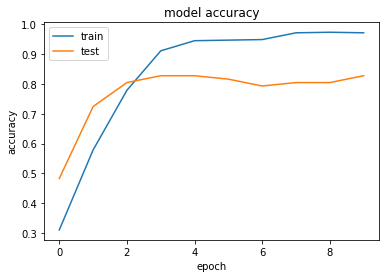

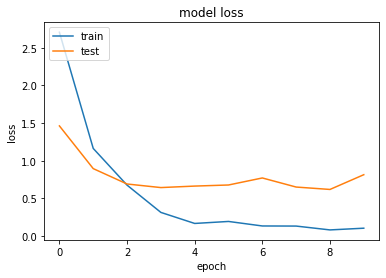

16/16 [==============================] - 21s 1s/step
Test evaluation:
16/16 [==============================] - 22s 1s/step - loss: 0.8216 - accuracy: 0.7727
[0.8215738534927368, 0.7727272510528564]
% of correct brand in the first 3 positions:
150
0.974025974025974
% of brand predicted with percentage >= 0.25
0.2662337662337662
% of brand predicted with percentage >= 0.5
0.2662337662337662
% of brand predicted with percentage >= 0.75
0.2662337662337662
Matriz de confusión:


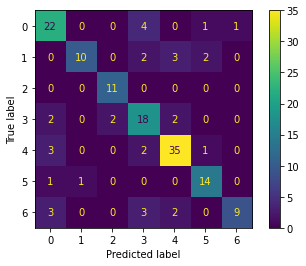

Time used: 0:29:59.820660


In [37]:
start = datetime.now()
history, model_10_noaum_280 = fitModelSize(False, True, True, True, 10, 280, 832)
end= datetime.now()

print("Time used: "+str(end-start))

 
Training model with aumentation:True, gray:True, binary:True, crop:True and epochs = 10
Epoch 1/10
53/53 [==============================] - 116s 2s/step - loss: 6.2758 - accuracy: 0.2930 - val_loss: 1.9363 - val_accuracy: 0.2874
Epoch 2/10
53/53 [==============================] - 114s 2s/step - loss: 1.9107 - accuracy: 0.3138 - val_loss: 1.9011 - val_accuracy: 0.3678
Epoch 3/10
53/53 [==============================] - 116s 2s/step - loss: 1.8537 - accuracy: 0.3384 - val_loss: 1.8715 - val_accuracy: 0.3678
Epoch 4/10
53/53 [==============================] - 128s 2s/step - loss: 1.7911 - accuracy: 0.3554 - val_loss: 1.8204 - val_accuracy: 0.3678
Epoch 5/10
53/53 [==============================] - 135s 3s/step - loss: 1.7052 - accuracy: 0.3781 - val_loss: 1.6062 - val_accuracy: 0.3908
Epoch 6/10
53/53 [==============================] - 138s 3s/step - loss: 1.6321 - accuracy: 0.4348 - val_loss: 1.4154 - val_accuracy: 0.5057
Epoch 7/10
53/53 [==============================] - 131s 2s/step

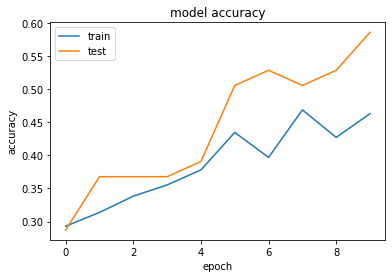

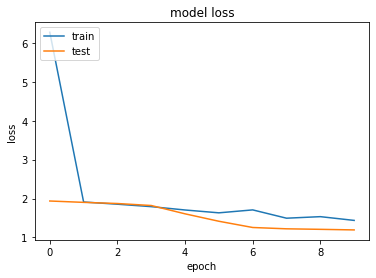

16/16 [==============================] - 18s 1s/step
Test evaluation:
16/16 [==============================] - 17s 1s/step - loss: 1.1877 - accuracy: 0.5455
[1.1876839399337769, 0.5454545617103577]
% of correct brand in the first 3 positions:
132
0.8571428571428571
% of brand predicted with percentage >= 0.25
0.1038961038961039
% of brand predicted with percentage >= 0.5
0.1038961038961039
% of brand predicted with percentage >= 0.75
0.0
Matriz de confusión:


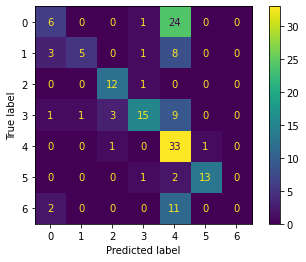

Time used: 0:21:36.113410


In [26]:
start = datetime.now()
history, model_10_aum_280 = fitModelSize(True, True, True, True, 10, 280, 832)
end= datetime.now()

print("Time used: "+str(end-start))

 
Training model with aumentation:False, gray:True, binary:True, crop:False and epochs = 10
Epoch 1/10
53/53 [==============================] - 77s 1s/step - loss: 1.9427 - accuracy: 0.2401 - val_loss: 1.8079 - val_accuracy: 0.3103
Epoch 2/10
53/53 [==============================] - 75s 1s/step - loss: 1.7907 - accuracy: 0.2930 - val_loss: 1.5445 - val_accuracy: 0.3448
Epoch 3/10
53/53 [==============================] - 75s 1s/step - loss: 1.5892 - accuracy: 0.3705 - val_loss: 1.3224 - val_accuracy: 0.5057
Epoch 4/10
53/53 [==============================] - 74s 1s/step - loss: 1.3674 - accuracy: 0.5123 - val_loss: 1.1014 - val_accuracy: 0.5862
Epoch 5/10
53/53 [==============================] - 73s 1s/step - loss: 1.1424 - accuracy: 0.5728 - val_loss: 1.1476 - val_accuracy: 0.5517
Epoch 6/10
53/53 [==============================] - 73s 1s/step - loss: 1.0045 - accuracy: 0.6219 - val_loss: 0.9162 - val_accuracy: 0.6782
Epoch 7/10
53/53 [==============================] - 73s 1s/step - lo

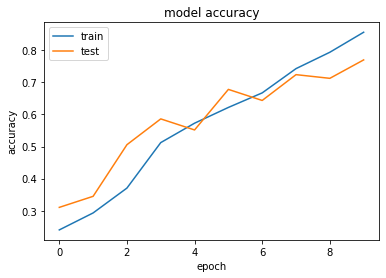

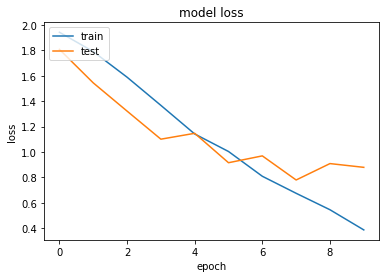

16/16 [==============================] - 19s 1s/step
Test evaluation:
16/16 [==============================] - 21s 1s/step - loss: 0.8777 - accuracy: 0.6753
[0.8776566386222839, 0.6753246784210205]
% of correct brand in the first 3 positions:
148
0.961038961038961
% of brand predicted with percentage >= 0.25
0.2922077922077922
% of brand predicted with percentage >= 0.5
0.0
% of brand predicted with percentage >= 0.75
0.0
Matriz de confusión:


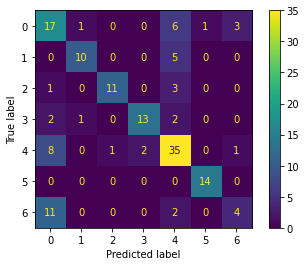

Time used: 0:13:01.026208


In [25]:
start = datetime.now()
history, model_10_noaum_104 = fitModelSize(False, True, True, False, 10, 104, 228)
end= datetime.now()

print("Time used: "+str(end-start))
    
    

 
Training model with aumentation:True, gray:True, binary:True, crop:False and epochs = 10
Epoch 1/10
53/53 [==============================] - 78s 1s/step - loss: 7.6793 - accuracy: 0.2042 - val_loss: 1.8617 - val_accuracy: 0.1609
Epoch 2/10
53/53 [==============================] - 77s 1s/step - loss: 7.1896 - accuracy: 0.2495 - val_loss: 1.8141 - val_accuracy: 0.3678
Epoch 3/10
53/53 [==============================] - 74s 1s/step - loss: 6.3771 - accuracy: 0.3025 - val_loss: 1.7317 - val_accuracy: 0.3678
Epoch 4/10
53/53 [==============================] - 76s 1s/step - loss: 6.5782 - accuracy: 0.3176 - val_loss: 1.6937 - val_accuracy: 0.3678
Epoch 5/10
53/53 [==============================] - 84s 2s/step - loss: 6.3003 - accuracy: 0.3119 - val_loss: 1.6589 - val_accuracy: 0.3678
Epoch 6/10
53/53 [==============================] - 76s 1s/step - loss: 6.8135 - accuracy: 0.3195 - val_loss: 1.6604 - val_accuracy: 0.3678
Epoch 7/10
53/53 [==============================] - 76s 1s/step - los

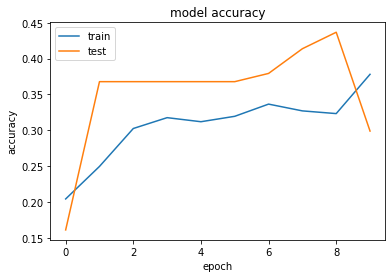

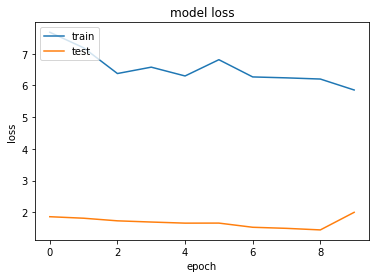

16/16 [==============================] - 18s 1s/step
Test evaluation:
16/16 [==============================] - 18s 1s/step - loss: 2.2170 - accuracy: 0.2792
[2.2170181274414062, 0.2792207896709442]
% of correct brand in the first 3 positions:
110
0.7142857142857143
% of brand predicted with percentage >= 0.25
0.21428571428571427
% of brand predicted with percentage >= 0.5
0.0
% of brand predicted with percentage >= 0.75
0.0
Matriz de confusión:


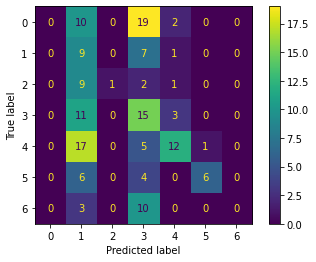

Time used: 0:13:29.581938


In [25]:
start = datetime.now()
history, model_10_aum_104 = fitModelSize(True, True, True, False, 10, 104, 228)
end= datetime.now()

print("Time used: "+str(end-start))

In [ ]:
#Ejemplo si quisieramos usar un modelo ya entrenado:
#if os.exists('models/full_10_nopre.h5'):
#    model_10_no_aum = load_model('models/full_10_nopre.h5', compile=False)

## Conclusiones 